In [1]:
import os
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

# Move kaggle.json to the correct directory
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Create the .kaggle directory if it doesn't exist
  !mkdir -p ~/.kaggle

  # Move the uploaded file
  !mv "{fn}" ~/.kaggle/

  # Set permissions
  !chmod 600 ~/.kaggle/kaggle.json

print("\nkaggle.json uploaded and moved to ~/.kaggle/")

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes

kaggle.json uploaded and moved to ~/.kaggle/


In [2]:
%pip install segmentation-models-pytorch kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.2 MB/s eta 0:00:00


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Path to dataset files: /kaggle/input/breast-ultrasound-images-dataset


In [4]:
!cp /kaggle/input/breast-ultrasound-images-dataset -r /content/

In [ ]:
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
import torchvision.transforms.functional as tf
from torch.utils.data import Dataset, DataLoader, random_split

torch.Size([3, 486, 550])


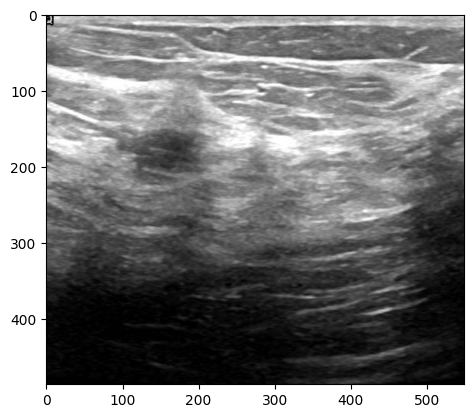

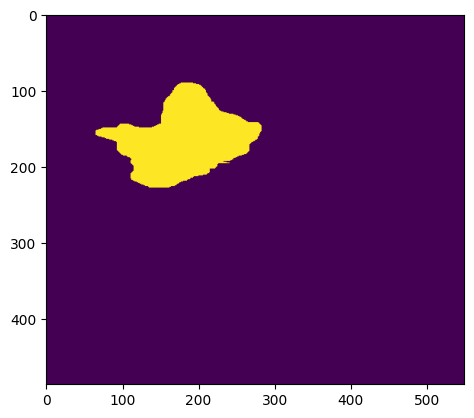

In [ ]:
path = '/content/breast-ultrasound-images-dataset'
img_path = path+'/Dataset_BUSI_with_GT/malignant/malignant (99).png'
mask_img_path = path + '/Dataset_BUSI_with_GT/malignant/malignant (99)_mask.png'
# If using PIL:
img = Image.open(img_path)
mask_img = Image.open(mask_img_path)

transform = transforms.ToTensor()
img_tensor = transform(img)
print(img_tensor.shape)
mask_img_tensor = transform(mask_img)
# Prepare for display
img_tensor = img_tensor.permute(1, 2, 0)
mask_img_tensor = mask_img_tensor.permute(1,2,0)
# If you have a batch dimension: image_tensor = image_tensor.squeeze(0)

# Display the image
plt.imshow(img_tensor)
plt.show()
plt.imshow(mask_img_tensor)
plt.show()

In [ ]:
import random
main_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
class BreastCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None, transform1=None):
        """
        Args:
            root_dir (str): Root directory containing 'normal', 'malignant', 'benign'.
            transform (callable, optional): Transform to apply to images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.transform1 = transform1
        self.image_paths = []
        self.mask_paths = []

        # Iterate over normal, malignant, benign folders
        for category in ['normal', 'malignant', 'benign']:
            category_path = os.path.join(root_dir, category)
            images = sorted([f for f in os.listdir(category_path) if "_mask" not in f])  # Exclude masks

            for img in images:
                img_path = os.path.join(category_path, img)
                mask_path = os.path.join(category_path, img.replace('.png', '_mask.png'))  # Assuming PNG format

                if os.path.exists(mask_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)

        # Shuffle the dataset before splitting
        combined = list(zip(self.image_paths, self.mask_paths))
        random.shuffle(combined)
        self.image_paths, self.mask_paths = zip(*combined)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Convert mask to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform1(mask)

        return image, mask  # Image as input, mask as label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize for consistency
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform1 = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize for consistency
    transforms.ToTensor()         # Convert to tensor
])

dataset = BreastCancerDataset(root_dir=main_dir, transform=transform, transform1=transform1)

train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Load dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
model = smp.Unet(
        encoder_name="resnet50",        # Encoder backbone
        encoder_weights="imagenet",     # Use pre-trained weights on ImageNet
        in_channels=3,                  # RGB images
        classes=1,                      # Single class (binary segmentation)
        activation=None                 # Activation is handled in loss calculation
    )

test_input = torch.randn((3, 3, 256, 256))
preds = model(test_input)
preds.shape

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

torch.Size([3, 1, 256, 256])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # 🔹 Upsample model output to match the mask size
        #outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:], mode="bilinear", align_corners=False)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    return avg_loss

In [ ]:
def iou_score(preds, targets, threshold=0.5, eps=1e-8):
    """
    Computes the Intersection over Union (IoU) score.

    preds: Model outputs (logits) of shape (N, 1, H, W)
    targets: Ground truth binary masks of shape (N, 1, H, W)
    threshold: Threshold to binarize predictions
    eps: Small constant to avoid division by zero
    """
    preds = (torch.sigmoid(preds) > threshold).float()  # Convert logits to binary mask
    intersection = (preds * targets).sum(dim=(1, 2, 3))  # Sum over spatial dims
    union = (preds + targets).clamp(0, 1).sum(dim=(1, 2, 3))  # Union calculation

    iou = (intersection + eps) / (union + eps)
    return iou.mean()  # Return mean IoU across batch

def test_model(model, test_loader, device):
    model.eval()
    iou_scores = []

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing", leave=False):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)

            # 🔹 Upsample model output to match the mask size
            #outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:], mode="bilinear", align_corners=False)

            iou = iou_score(outputs, masks)
            iou_scores.append(iou.item())  # Convert tensor to Python float

    avg_iou = sum(iou_scores) / len(iou_scores)
    return avg_iou

In [ ]:
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []
iou_at_epoch = []

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    test_iou = test_model(model, test_loader, device)
    iou_at_epoch.append(test_iou)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}, IoU: {test_iou:.4f}")

# 🔹 Save the trained model
torch.save(model.state_dict(), 'unet_breast_cancer_segmentation.pth')

Epoch [1/50] - Loss: 0.3344, IoU: 0.1259


Epoch [2/50] - Loss: 0.1885, IoU: 0.3680


Epoch [3/50] - Loss: 0.1587, IoU: 0.5372


Epoch [4/50] - Loss: 0.1481, IoU: 0.5459


Epoch [5/50] - Loss: 0.1322, IoU: 0.3264


Epoch [6/50] - Loss: 0.1285, IoU: 0.2273


Epoch [7/50] - Loss: 0.1223, IoU: 0.4645


Epoch [8/50] - Loss: 0.1166, IoU: 0.5707


Epoch [9/50] - Loss: 0.1104, IoU: 0.5266


Epoch [10/50] - Loss: 0.1017, IoU: 0.4514


Epoch [11/50] - Loss: 0.1031, IoU: 0.4428


Epoch [12/50] - Loss: 0.0815, IoU: 0.3688


Epoch [13/50] - Loss: 0.0710, IoU: 0.4095


Epoch [14/50] - Loss: 0.0725, IoU: 0.3990


Epoch [15/50] - Loss: 0.1107, IoU: 0.5689


Epoch [16/50] - Loss: 0.0987, IoU: 0.3756


Epoch [17/50] - Loss: 0.0761, IoU: 0.5878


Epoch [18/50] - Loss: 0.0604, IoU: 0.6884


Epoch [19/50] - Loss: 0.0509, IoU: 0.6615


Epoch [20/50] - Loss: 0.0623, IoU: 0.6074


Epoch [21/50] - Loss: 0.0806, IoU: 0.5270


Epoch [22/50] - Loss: 0.0628, IoU: 0.6288


Epoch [23/50] - Loss: 0.0509, IoU: 0.5837


Epoch [24/50] - Loss: 0.0479, IoU: 0.6209


Epoch [25/50] - Loss: 0.0400, IoU: 0.6248


Epoch [26/50] - Loss: 0.0354, IoU: 0.6412


Epoch [27/50] - Loss: 0.0323, IoU: 0.7197


Epoch [28/50] - Loss: 0.0324, IoU: 0.7438


Epoch [29/50] - Loss: 0.0310, IoU: 0.6272


Epoch [30/50] - Loss: 0.0273, IoU: 0.6565


Epoch [31/50] - Loss: 0.0287, IoU: 0.5870


Epoch [32/50] - Loss: 0.0286, IoU: 0.6131


Epoch [33/50] - Loss: 0.0258, IoU: 0.6823


Epoch [34/50] - Loss: 0.0341, IoU: 0.5945


Epoch [35/50] - Loss: 0.0467, IoU: 0.5639


Epoch [36/50] - Loss: 0.0357, IoU: 0.6241


Epoch [37/50] - Loss: 0.0337, IoU: 0.6761


Epoch [38/50] - Loss: 0.0299, IoU: 0.6366


Epoch [39/50] - Loss: 0.0250, IoU: 0.6258


Epoch [40/50] - Loss: 0.0260, IoU: 0.6493


Epoch [41/50] - Loss: 0.0448, IoU: 0.4616


Epoch [42/50] - Loss: 0.1317, IoU: 0.4270


Epoch [43/50] - Loss: 0.0847, IoU: 0.6213


Epoch [44/50] - Loss: 0.0617, IoU: 0.5641


Epoch [45/50] - Loss: 0.0451, IoU: 0.6718


Epoch [46/50] - Loss: 0.0393, IoU: 0.6502


Epoch [47/50] - Loss: 0.0467, IoU: 0.6495


Epoch [48/50] - Loss: 0.0366, IoU: 0.5353


Epoch [49/50] - Loss: 0.0285, IoU: 0.6479


Epoch [50/50] - Loss: 0.0289, IoU: 0.6474


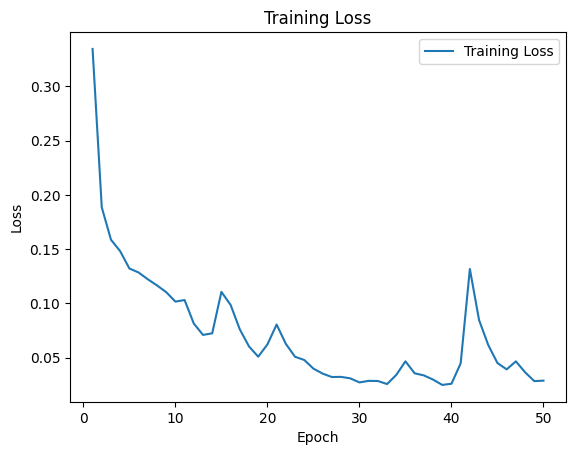

In [ ]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

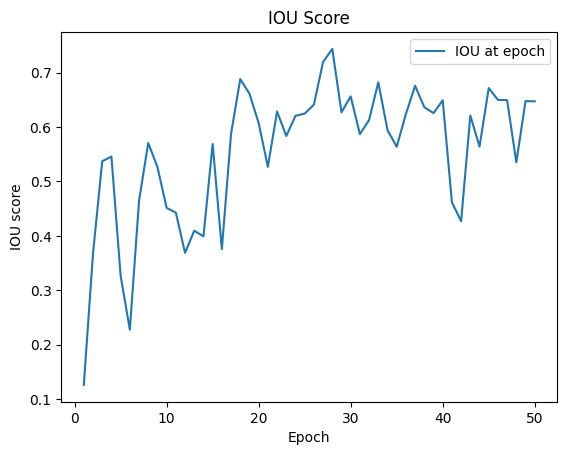

In [ ]:
plt.plot(range(1, len(iou_at_epoch) + 1), iou_at_epoch, label='IOU at epoch')
plt.xlabel('Epoch')
plt.ylabel('IOU score')
plt.title('IOU Score')
plt.legend()
plt.show()

In [5]:
import os
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

Saving unet_breast_cancer_segmentation.pth to unet_breast_cancer_segmentation.pth


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

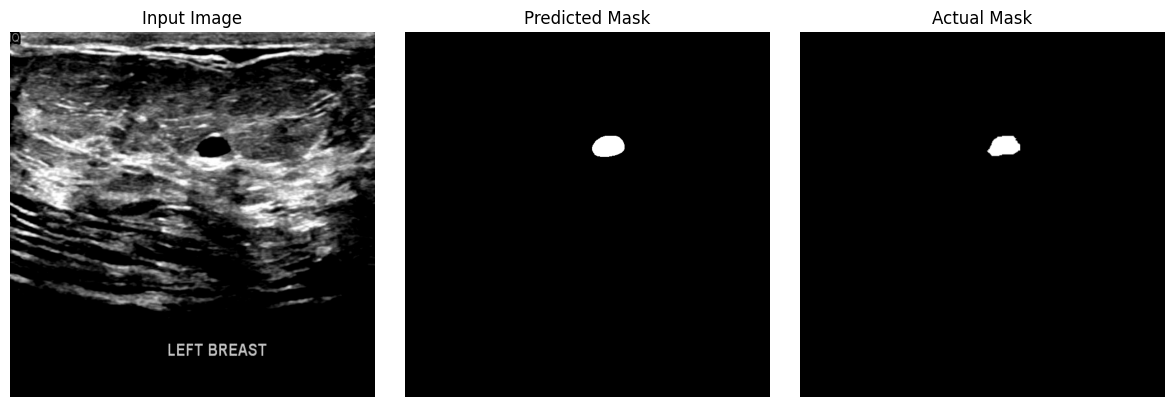

In [9]:
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
import torchvision.transforms.functional as tf
from torch.utils.data import Dataset, DataLoader, random_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

main_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
model = smp.Unet(
        encoder_name="resnet50",        # Encoder backbone
        encoder_weights="imagenet",     # Use pre-trained weights on ImageNet
        in_channels=3,                  # RGB images
        classes=1,                      # Single class (binary segmentation)
        activation=None                 # Activation is handled in loss calculation
    )

test_input = torch.randn((3, 3, 256, 256))
preds = model(test_input)
preds.shape

image = Image.open(main_dir + '/benign/benign (1).png').convert("RGB")
mask = Image.open(main_dir + '/benign/benign (1)_mask.png').convert("L")

transform = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize for consistency
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform1 = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize for consistency
    transforms.ToTensor()         # Convert to tensor
])

input_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
input_mask = transform1(mask).unsqueeze(0).to(device)     # Add batch dimension

# Load the saved model weights
model.load_state_dict(torch.load('unet_breast_cancer_segmentation.pth'))
model.to(device)
model.eval()

with torch.no_grad():
    prediction = model(input_image)
    predicted_mask = (torch.sigmoid(prediction) > 0.5).float()

# Remove batch dimension for visualization
input_image = input_image.squeeze(0).permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
predicted_mask = predicted_mask.squeeze(0).squeeze(0)  # (1, 256, 256) -> (256, 256)
input_mask = input_mask.squeeze(0).squeeze(0)          # Ground truth mask

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_image.cpu())
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask.cpu(), cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(input_mask.cpu(), cmap='gray')
plt.title("Actual Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


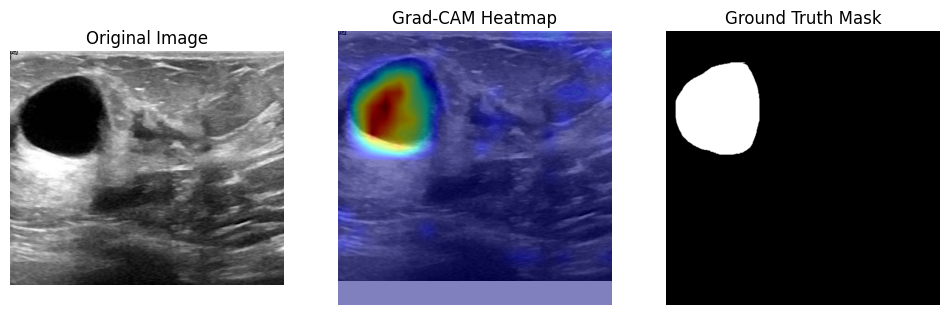

In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# ✅ Grad-CAM for segmentation
class SegmentationGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # Hook to save activations
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Hook to save gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_mask=None):
        self.model.zero_grad()
        output = self.model(input_image)

        # Use BCE loss with target mask for gradients
        if target_mask is not None:
            loss = F.binary_cross_entropy_with_logits(output, target_mask)
            loss.backward()
        else:
            # If no target mask, just use mean prediction
            output.mean().backward()

        gradients = self.gradients.mean(dim=(2, 3), keepdim=True)  # Global average pooling
        weighted_activations = (gradients * self.activations).sum(dim=1, keepdim=True)

        cam = F.relu(weighted_activations)  # Apply ReLU
        cam = F.interpolate(cam, size=input_image.shape[2:], mode="bilinear", align_corners=False)
        cam = cam.squeeze().cpu().numpy()

        # Normalize between 0-1
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# ✅ Apply Grad-CAM
grad_cam = SegmentationGradCAM(model, model.encoder.layer4[-1])  # Last encoder layer

# Example input
image = Image.open(main_dir + '/benign/benign (10).png').convert("RGB")
mask = Image.open(main_dir + '/benign/benign (10)_mask.png').convert("L")

input_image = transform(image).unsqueeze(0).to(device)
input_mask = transform1(mask).unsqueeze(0).to(device)

# Generate CAM
cam = grad_cam.generate_cam(input_image, input_mask)

# Visualization
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(image)
plt.imshow(cam, cmap="jet", alpha=0.5)  # Overlay heatmap
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(input_mask.squeeze().cpu(), cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.show()


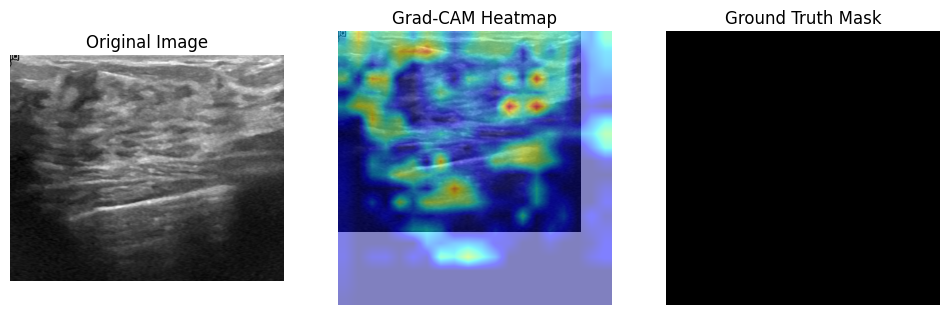

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# ✅ Grad-CAM for segmentation
class SegmentationGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # Hook to save activations
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Hook to save gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_mask=None):
        self.model.zero_grad()
        output = self.model(input_image)

        # Use BCE loss with target mask for gradients
        if target_mask is not None:
            loss = F.binary_cross_entropy_with_logits(output, target_mask)
            loss.backward()
        else:
            # If no target mask, just use mean prediction
            output.mean().backward()

        gradients = self.gradients.mean(dim=(2, 3), keepdim=True)  # Global average pooling
        weighted_activations = (gradients * self.activations).sum(dim=1, keepdim=True)

        cam = F.relu(weighted_activations)  # Apply ReLU
        cam = F.interpolate(cam, size=input_image.shape[2:], mode="bilinear", align_corners=False)
        cam = cam.squeeze().cpu().numpy()

        # Normalize between 0-1
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# ✅ Apply Grad-CAM
grad_cam = SegmentationGradCAM(model, model.encoder.layer4[-1])  # Last encoder layer

# Example input
image = Image.open(main_dir + '/normal/normal (1).png').convert("RGB")
mask = Image.open(main_dir + '/normal/normal (1)_mask.png').convert("L")

input_image = transform(image).unsqueeze(0).to(device)
input_mask = transform1(mask).unsqueeze(0).to(device)

# Generate CAM
cam = grad_cam.generate_cam(input_image, input_mask)

# Visualization
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(image)
plt.imshow(cam, cmap="jet", alpha=0.5)  # Overlay heatmap
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(input_mask.squeeze().cpu(), cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.show()
